# Preperation

In [ ]:
!pip install grad-cam
RootDir = "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project"
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project"

     |████████████████████████████████| 4.5 MB 8.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=31eb2bdce4ef8481100407b83c0944ee0b552130910504d047945caab9f5ceb6
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam
Mounted at /content/gdrive
/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project


In [ ]:
# !mkdir data
%cd data
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data


In [ ]:
# !tar -xzf "images.tar.gz"
# !tar -xzf "annotations.tar.gz"

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, vgg16
import torch
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

!pip install pretrainedmodels
import pretrainedmodels

import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

import torch.nn as nn
import torch.nn.functional as F

import os
import torch
import pandas as pd
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
import glob
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 58 kB 4.7 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=4b75a44126aad0df596a8725b31bb149b5484565ceee2345b1c9d41f7d760b68
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [ ]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

# Construct the CAM object once, and then re-use it on many images:
cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)

targets = [ClassifierOutputTarget(281)]

rgb_img = cv2.imread("/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/images/Abyssinian_1.jpg", 1)[:, :, ::-1]
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]).to(device)
targets = None
input_tensor.shape

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([1, 3, 400, 600])

In [ ]:
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


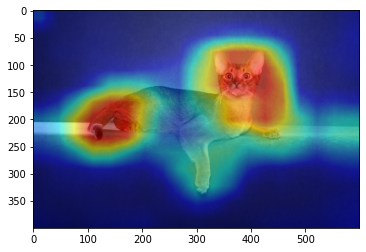

In [ ]:
plt.imshow(visualization)

## Dataset

In [ ]:
class PetDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.label_data = pd.read_csv(csv_file, sep='\s+')
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0] + ".jpg")
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        if self.transform:
            image = self.transform(image)
        # image = transforms.functional.to_tensor(image)
        classid = self.label_data.iloc[idx, 1] - 1 # 0:36 class ids
        species = self.label_data.iloc[idx, 2] - 1 # 0:Cat 1:Dog
        sample = {'image': image, 'classid': classid, 'species': species, 'img_name':img_name}

        return sample #generates pairs of objectt

In [ ]:
pet_dataset = PetDataset(csv_file="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/trainval.txt",
                         root_dir="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/images",
                         transform = transforms.Compose(
                                      [transforms.ToTensor(),
                                       transforms.Resize((128, 128)),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
classid = pet_dataset.label_data.iloc[:, 1]
index = np.array(range(len(classid)))
train_idx, val_idx, y_train, y_test = train_test_split(index, classid, test_size=0.1, stratify=classid)

train_dataset = torch.utils.data.Subset(pet_dataset, train_idx)
val_dataset = torch.utils.data.Subset(pet_dataset, val_idx)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

In [ ]:
'''
for i in range(3678):
  if pet_dataset[i]["classid"] < 0 or pet_dataset[i]["classid"] >36:
    print("Error: ", i)
'''

'\nfor i in range(3678):\n  if pet_dataset[i]["classid"] < 0 or pet_dataset[i]["classid"] >36:\n    print("Error: ", i)\n'

## Classification Model

In [ ]:
class res_CNN(nn.Module):
    def __init__(self):
        super(res_CNN, self).__init__()
        self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        # self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        # self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        # self.dropout = nn.Dropout(p=0.5)
        # self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(2048*4*4, 1024)
        self.fc2 = nn.Linear(1024, 2)
        
    def forward(self, x): # 128 x 128
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        # x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.dropout(x)
        # x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        x = self.fc1(x.reshape(bs, -1))  # [8, 2048*4*4]
        label = self.fc2(x)
        return label

class vgg_CNN(nn.Module): # 224 x 224
  def __init__(self):
        super(vgg_CNN, self).__init__()
        self.model = pretrainedmodels.__dict__["vgg16"](pretrained="imagenet")
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 2)
        
  def forward(self, x):
      bs, _, _, _ = x.shape
      x = self.model.features(x)
      x = self.fc1(x.reshape(bs, -1))  # [8, 2048*4*4]
      x = F.relu(x)
      label = self.fc2(x)
      return label

def train_model(model, criterion, optimizer, n_epochs=40):
    valid_loss_max = 0.9 # Acc of saved model

    batch_size = 200
    for epoch in range(1, n_epochs):
      k = (epoch-1)*batch_size
      train = [0,1,2,3]
      train_loss = 0.0
      valid_loss = 0.0
      # train the model #
      model.train()
      for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['species'].to(device)
            optimizer.zero_grad()
            output=model(image)

            loss = criterion(output, label)
            loss.backward()

            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
                
      # validate the model #
      model.eval()
      for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['species'].to(device)
            output = model(image)
            _, predicted = torch.max(output, 1)
            train_acc = torch.sum(predicted == label) / len(label)
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (train_acc - valid_loss))

      # print training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      ## TODO: save the model if validation loss has decreased
      if valid_loss > valid_loss_max:
          torch.save(model.state_dict(), '/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/model_clf.pt')
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_max,
          valid_loss))
          valid_loss_max = valid_loss
    # return trained model
    return model

## Res Net

In [ ]:
model_CNN = res_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
torch.cuda.empty_cache()

model_conv=train_model(model_conv, criterion, optimizer)

Epoch 1, Batch 1 loss: 0.215609
Epoch 1, Batch 101 loss: 0.121003
Epoch: 1 	Training Loss: 0.120874 	Validation Loss: 0.799479
Epoch 2, Batch 1 loss: 0.085628
Epoch 2, Batch 101 loss: 0.072351
Epoch: 2 	Training Loss: 0.071790 	Validation Loss: 0.809896
Epoch 3, Batch 1 loss: 0.035539
Epoch 3, Batch 101 loss: 0.043935
Epoch: 3 	Training Loss: 0.043283 	Validation Loss: 0.825521
Epoch 4, Batch 1 loss: 0.025962
Epoch 4, Batch 101 loss: 0.016423
Epoch: 4 	Training Loss: 0.016649 	Validation Loss: 0.822917
Epoch 5, Batch 1 loss: 0.056074
Epoch 5, Batch 101 loss: 0.039658
Epoch: 5 	Training Loss: 0.040624 	Validation Loss: 0.796875
Epoch 6, Batch 1 loss: 0.094274
Epoch 6, Batch 101 loss: 0.065450
Epoch: 6 	Training Loss: 0.066462 	Validation Loss: 0.820312
Epoch 7, Batch 1 loss: 0.046821
Epoch 7, Batch 101 loss: 0.078278
Epoch: 7 	Training Loss: 0.077758 	Validation Loss: 0.809896
Epoch 8, Batch 1 loss: 0.014094
Epoch 8, Batch 101 loss: 0.030520
Epoch: 8 	Training Loss: 0.032778 	Validation

In [ ]:
pet_testdataset = PetDataset(csv_file="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/test.txt",
                         root_dir="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/images",
                         transform = transforms.Compose(
                                      [transforms.ToTensor(),
                                       transforms.Resize((128, 128)),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
test_dataloader = DataLoader(pet_testdataset, batch_size=32, num_workers=0)

def model_acc(model, test_dataloader):

    accuracy = 0.0
              
    # validate the model #
    model.eval()
    for batch_idx, sample_batched in enumerate(test_dataloader):
      image, label = sample_batched['image'].to(device), sample_batched['species'].to(device)
      output = model(image)
      _, predicted = torch.max(output, 1)
      test_acc = torch.sum(predicted == label) / len(label)
      accuracy = accuracy + ((1 / (batch_idx + 1)) * (test_acc - accuracy))
    
    print("Accuracy: ", accuracy)

    return accuracy

best_clf = res_CNN().to(device)
best_clf.load_state_dict(torch.load('/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/model_clf.pt'))
model_acc(best_clf, test_dataloader)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Accuracy:  tensor(0.8779, device='cuda:0')


tensor(0.8779, device='cuda:0')

## VGG

In [ ]:
'''
vgg_conv = vgg_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_conv.parameters(), lr=0.001, weight_decay=0.0001)
torch.cuda.empty_cache()
vgg_conv=train_model(vgg_conv, criterion, optimizer)

pet_testdataset = PetDataset(csv_file="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/test.txt",
                         root_dir="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/images",
                         transform = transforms.Compose(
                                      [transforms.ToTensor(),
                                       transforms.Resize((224, 224)),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
test_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=0)

def model_acc(model, test_dataloader):

    accuracy = 0.0
              
    # validate the model #
    model.eval()
    for batch_idx, sample_batched in enumerate(test_dataloader):
      image, label = sample_batched['image'].to(device), sample_batched['species'].to(device)
      output = model(image)
      _, predicted = torch.max(output, 1)
      test_acc = torch.sum(predicted == label) / len(label)
      accuracy = accuracy + ((1 / (batch_idx + 1)) * (test_acc - accuracy))
    
    print("Accuracy: ", accuracy)

    return accuracy

model_acc(vgg_conv, test_dataloader)
'''

'\nvgg_conv = vgg_CNN().to(device)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(vgg_conv.parameters(), lr=0.001, weight_decay=0.0001)\ntorch.cuda.empty_cache()\nvgg_conv=train_model(vgg_conv, criterion, optimizer)\n\npet_testdataset = PetDataset(csv_file="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/test.txt",\n                         root_dir="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/images",\n                         transform = transforms.Compose(\n                                      [transforms.ToTensor(),\n                                       transforms.Resize((224, 224)),\n                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))\ntest_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=0)\n\ndef model_acc(model, test_dataloader):\n\n    accuracy = 0.0\n              \n    # validate the model #\n    model.eval()\n    for batch_idx, sample_b

## Effect of fine-tuned CAM

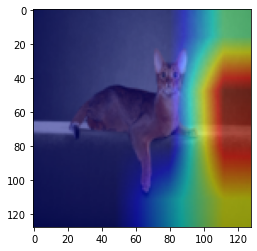

In [ ]:
def get_cam(model, target_layers, image_path):
  testcam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
  rgb_img = cv2.imread(image_path, 1)
  preprocess = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((128, 128)),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  input_tensor = torch.unsqueeze(preprocess(rgb_img), 0)

  PIL_image = Image.fromarray(np.uint8(rgb_img))
  down_sampler = transforms.Resize((128, 128))
  sampled_pil = down_sampler(PIL_image)
  sampled_img = np.array(sampled_pil)[:, :, ::-1]
  
  gray_cam = testcam(input_tensor=input_tensor, targets=None)
  gray_cam = gray_cam[0, :]

  visualization = show_cam_on_image(sampled_img / 255, gray_cam, use_rgb=True)
  _ = plt.imshow(visualization)

  output_tensor = model(input_tensor.to(device))

  return sampled_img, visualization, output_tensor, input_tensor

target_layers = [best_clf.model.layer4[-1]]
_ = get_cam(best_clf, target_layers, "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/images/Abyssinian_1.jpg")

torch.Size([1, 3, 128, 128])


100%|██████████| 32/32 [00:00<00:00, 34.93it/s]


torch.Size([1, 3, 128, 128])


100%|██████████| 32/32 [00:00<00:00, 34.12it/s]


torch.Size([1, 3, 128, 128])


100%|██████████| 32/32 [00:00<00:00, 36.07it/s]


torch.Size([1, 3, 128, 128])


100%|██████████| 32/32 [00:00<00:00, 36.25it/s]


torch.Size([1, 3, 128, 128])


100%|██████████| 32/32 [00:00<00:00, 36.12it/s]


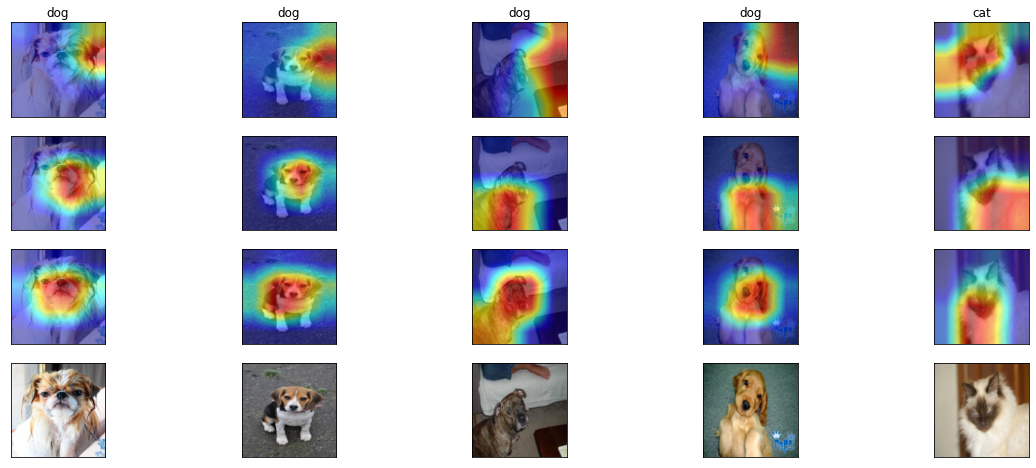

In [ ]:
import random
target_layers = [best_clf.model.layer4[-1]]
plt.figure(figsize =(20, 8))
posi = 1
for i in random.sample(range(0, 1000), 5):
  ax = plt.subplot(4, 5, posi)
  image_path = pet_dataset[i]["img_name"]
  original, camed, pred, input_tensor = get_cam(best_clf, target_layers, image_path)
  label = ["cat", "dog"][torch.max(pred, 1)[1].item()]
  plt.title(label)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(4, 5, posi+5)
  rawmodel = resnet50(pretrained=True)
  raw_target_layers = [rawmodel.layer4[-1]] 
  raw_cam = EigenCAM(model=rawmodel, target_layers=raw_target_layers, use_cuda=use_cuda)
  raw_grayscale_cam = raw_cam(input_tensor=input_tensor, targets=targets)[0, :]
  visualization = show_cam_on_image(original/255, raw_grayscale_cam, use_rgb=True)
  _ = plt.imshow(visualization)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(4, 5, posi+10)
  vggmodel = vgg16(pretrained=True)
  vgg_target_layers = [vggmodel.features[-1]] 
  vgg_cam = ScoreCAM(model=vggmodel, target_layers=vgg_target_layers, use_cuda=use_cuda)
  print(input_tensor.shape)
  vgg_grayscale_cam = vgg_cam(input_tensor=input_tensor, targets=targets)[0, :]
  visualization = show_cam_on_image(original/255, vgg_grayscale_cam, use_rgb=True)
  _ = plt.imshow(visualization)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


  ax = plt.subplot(4, 5, posi+15)
  plt.imshow(original)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  posi += 1
  

## Save resulting cams

In [ ]:
torch.cuda.empty_cache()
dump_model = vgg16(pretrained=True)
dump_target_layers = [dump_model.features[-1]] 
dump_process = transforms.Compose([transforms.ToTensor(),
                                    # transforms.Resize((128, 128)),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
label_data = pet_dataset.label_data

with EigenCAM(model=dump_model, target_layers=dump_target_layers, use_cuda=True) as dump_cam:
  for i in range(2700, len(label_data)):
    print(i)
    image_path = pet_dataset[i]["img_name"]
    dump_img = cv2.imread(image_path, 1)
    dump_input_tensor = torch.unsqueeze(dump_process(dump_img), 0)
    dump_grayscale_cam = dump_cam(input_tensor=dump_input_tensor, targets=None)[0, :]

    save_path = os.path.join("/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/cam_score", label_data.iloc[i, 0] + ".npy")
    np.save(save_path, dump_grayscale_cam)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899


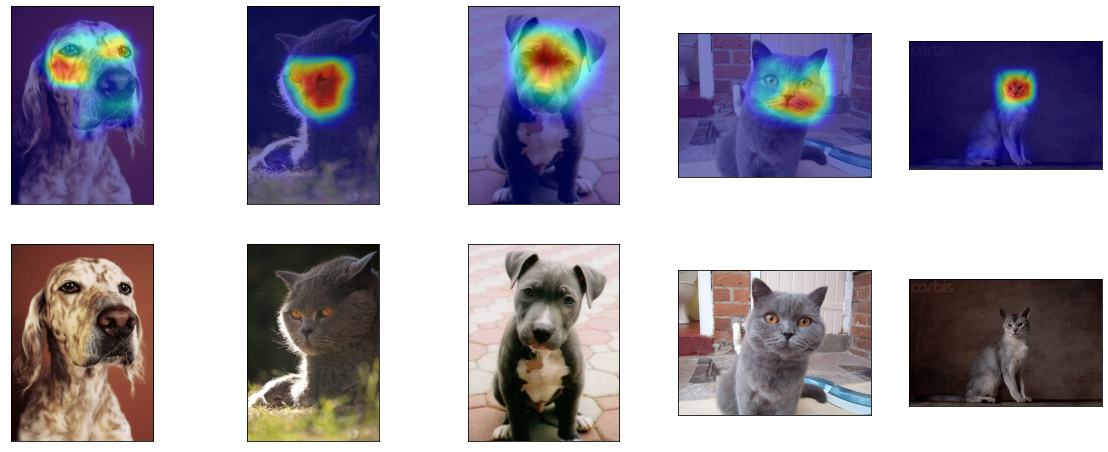

In [ ]:
import random
posi = 1
plt.figure(figsize =(20, 8))
for i in random.sample(range(0, 1000), 5):
  ax = plt.subplot(2, 5, posi)
  image_path = pet_dataset[i]["img_name"]
  dump_img = cv2.imread(image_path, 1)[:, :, ::-1]

  restore_path = os.path.join("/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/cam_score", label_data.iloc[i, 0] + ".npy")
  restored_cam = np.load(restore_path)
  visualization = show_cam_on_image(dump_img/255, restored_cam, use_rgb=True)

  plt.imshow(visualization)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, 5, posi+5)
  plt.imshow(dump_img/255)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  posi += 1